In [55]:
##Setting up the python environment
import pandas as pd
import os 
import re
from collections import Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import string
%matplotlib inline 
import textwrap

##Setting up BQ API
from google.cloud import bigquery

# pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


##Setting up Google sdk environment
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/jupyter/.config/gcloud/application_default_credentials.json'
## Connect to the right GCP project
os.environ['GCLOUD_PROJECT'] = 'som-nero-egyang-starr' 
%load_ext google.cloud.bigquery
client=bigquery.Client()

project_id = "som-rit-phi-starr-prod"
# dataset_id = "starr_omop_cdm5_deid_1pcent_latest"
dataset_id = "starr_omop_cdm5_deid_latest"
work_project_id = 'som-nero-egyang-starr' 
work_dataset_id = 'ilies_explore'

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


/opt/conda/lib/python3.7/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


## Test set

In [15]:
fold_num = 1
query="""
(SELECT a.* EXCEPT (PAD, Smoking_status), 1 AS label
FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp_smok` a
JOIN `{work_project_id}.{work_dataset_id}.person_ids_cases_sequence_fold_{fold_num}` b
ON a.person_id = b.person_id
WHERE a.person_id NOT IN (
SELECT *
FROM `{work_project_id}.{work_dataset_id}.321052_ids`)
)
UNION ALL
(SELECT a.* EXCEPT (PAD, Smoking_status), 0 AS label
FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp_smok` a
JOIN `{work_project_id}.{work_dataset_id}.person_ids_controls_sequence_fold_{fold_num}` b
ON a.person_id = b.person_id)
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df
df.to_csv("data_{fold_num}.csv".format_map({'fold_num': fold_num}), index=False, header=True)

In [16]:
df_ids = pd.read_csv("/home/jupyter/PAD_npj/random_forest/cv/person_ids/testids_fold{fold_num}.csv".format_map({'fold_num': fold_num}))
df_ids = df_ids.drop_duplicates(subset=['test_person_id'])
df_ids.head()

df_test = df.loc[df['person_id'].isin(df_ids['test_person_id'])].drop_duplicates(subset=['person_id'])
len(df_test)

sort_mapping = df_ids.reset_index().set_index('test_person_id')
sort_mapping

df_test['person_id_num'] = df_test['person_id'].map(sort_mapping['index'])
df_test

df_test = df_test.sort_values('person_id_num')
df_test

df_test = df_test.drop(columns=['person_id_num'])
df_test

df_test = df_test.reset_index().drop(columns=['index'])
df_test


,person_id,Age,Female,Race,CVA,CAD,HF,HTN,Diab,HLD,BMI,new_Smoking_status,label
0,31948706,55,1.0,Caucasian,0,1,0,1,0,0,17.380565,Ever,0
1,30909788,53,1.0,Hispanic,0,0,0,0,0,0,33.540800,Never,0
2,30689388,68,0.0,Caucasian,0,0,0,0,0,0,36.332258,Never,0
3,31993380,56,1.0,Caucasian,0,0,0,0,0,0,22.849041,Ever,0
4,31911607,67,0.0,Caucasian,0,1,0,1,0,0,28.440038,Never,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2421,30685667,57,0.0,Hispanic,0,1,0,1,0,1,33.076750,Ever,0
2422,31689180,70,0.0,Caucasian,0,0,0,0,0,0,28.538487,Never,0
2423,30554833,72,0.0,Caucasian,0,1,0,1,0,0,22.541136,Current,0
2424,30570307,62,0.0,Caucasian,0,1,1,1,0,0,31.458816,Current,0


In [17]:
fold_num = 1
query="""
(SELECT a.* EXCEPT (PAD, Smoking_status), 1 AS label
FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp_smok` a

WHERE a.person_id NOT IN (
SELECT *
FROM `{work_project_id}.{work_dataset_id}.321052_ids`)
)
UNION ALL
(SELECT a.* EXCEPT (PAD, Smoking_status), 0 AS label
FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp_smok` a
)
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df
df.to_csv("data_DUVAL.csv".format_map({'fold_num': fold_num}), index=False, header=True)

In [18]:
df_test.isnull().sum().sum()

2

In [19]:
df_test[df_test.isna().any(axis=1)]


,person_id,Age,Female,Race,CVA,CAD,HF,HTN,Diab,HLD,BMI,new_Smoking_status,label
285,31989705,59,1.0,Hispanic,0,1,0,1,1,1,NaN,Ever,0
1617,31945721,56,1.0,Caucasian,0,1,0,1,0,0,NaN,Ever,0


In [20]:
df_test = df_test.fillna(30)

In [21]:
df_test.loc[[293, 1657]]

,person_id,Age,Female,Race,CVA,CAD,HF,HTN,Diab,HLD,BMI,new_Smoking_status,label
293,32033877,77,0.0,Hispanic,1,1,1,1,0,1,23.335345,Never,1
1657,31849425,63,1.0,Hispanic,0,1,0,1,0,1,22.114254,Ever,0


In [22]:
df_test = df_test.drop("person_id",axis = 1)
df_test["Female"] = df_test["Female"].astype("category")
df_test["Race"] = df_test["Race"].astype("category")
df_test["CVA"] = df_test["CVA"].astype("category")
df_test["CAD"] = df_test["CAD"].astype("category")
df_test["HF"] = df_test["HF"].astype("category")
df_test["HTN"] = df_test["HTN"].astype("category")
df_test["Diab"] = df_test["Diab"].astype("category")
df_test["HLD"] = df_test["HLD"].astype("category")
df_test["new_Smoking_status"] = df_test["new_Smoking_status"].astype("category")

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_test["Race"])
list(le.classes_)
df_test["Race"] = le.transform(df_test["Race"])

le = preprocessing.LabelEncoder()
le.fit(df_test["new_Smoking_status"])
list(le.classes_)
df_test["new_Smoking_status"] = le.transform(df_test["new_Smoking_status"])

In [23]:
X_test = df_test.drop("label",axis = 1) 
y_test = df_test.label

In [24]:
sum(df_test['label'])/len(df_test)*100

26.009892827699915

In [25]:
X_test

,Age,Female,Race,CVA,CAD,HF,HTN,Diab,HLD,BMI,new_Smoking_status
0,55,1.0,2,0,1,0,1,0,0,17.380565,1
1,53,1.0,3,0,0,0,0,0,0,33.540800,2
2,68,0.0,2,0,0,0,0,0,0,36.332258,2
3,56,1.0,2,0,0,0,0,0,0,22.849041,1
4,67,0.0,2,0,1,0,1,0,0,28.440038,2
...,...,...,...,...,...,...,...,...,...,...,...
2421,57,0.0,3,0,1,0,1,0,1,33.076750,1
2422,70,0.0,2,0,0,0,0,0,0,28.538487,2
2423,72,0.0,2,0,1,0,1,0,0,22.541136,0
2424,62,0.0,2,0,1,1,1,0,0,31.458816,0


## Training set

In [26]:
fold1 = pd.read_csv("data_2.csv")
fold2 = pd.read_csv("data_3.csv")
fold3 = pd.read_csv("data_5.csv")

In [27]:
df_train = pd.concat([fold1, fold2, fold3]) 
df_train = df_train.drop("person_id",axis = 1)
df_train["Female"] = df_train["Female"].astype("category")
df_train["Race"] = df_train["Race"].astype("category")
df_train["CVA"] = df_train["CVA"].astype("category")
df_train["CAD"] = df_train["CAD"].astype("category")
df_train["HF"] = df_train["HF"].astype("category")
df_train["HTN"] = df_train["HTN"].astype("category")
df_train["Diab"] = df_train["Diab"].astype("category")
df_train["HLD"] = df_train["HLD"].astype("category")
df_train["new_Smoking_status"] = df_train["new_Smoking_status"].astype("category")

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_train["Race"])
list(le.classes_)
df_train["Race"] = le.transform(df_train["Race"])

le = preprocessing.LabelEncoder()
le.fit(df_train["new_Smoking_status"])
list(le.classes_)
df_train["new_Smoking_status"] = le.transform(df_train["new_Smoking_status"])
df_train = df_train.reset_index().drop(columns=['index'])
df_train = df_train.dropna()

X_train = df_train.drop("label",axis = 1) 
y_train = df_train.label

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)

## Logistic regression

In [28]:
import pandas as pd
import numpy as np
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [29]:
logistic_regression = LogisticRegression()

In [30]:
logistic_regression.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [31]:
y_pred = logistic_regression.predict_proba(X_test)[:,1]
y_pred

array([0.04199407, 0.02291872, 0.05244901, ..., 0.02253846, 0.02446891,
       0.12071123])

In [32]:
np.mean(y_pred)

0.13018376584059752

In [33]:
np.mean(y_test)

0.26009892827699915

In [34]:
sum(y_test)

631

In [35]:
# logistic_regression.importance

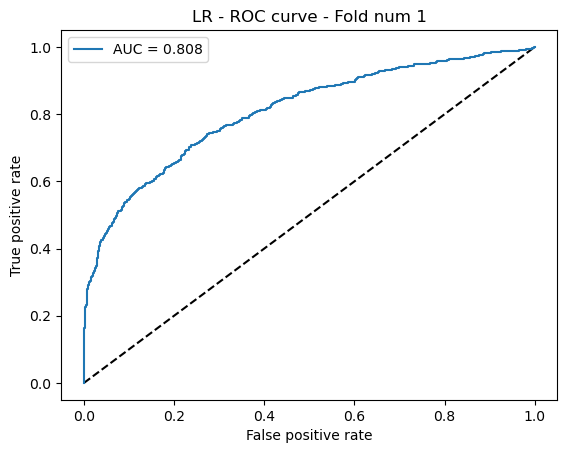

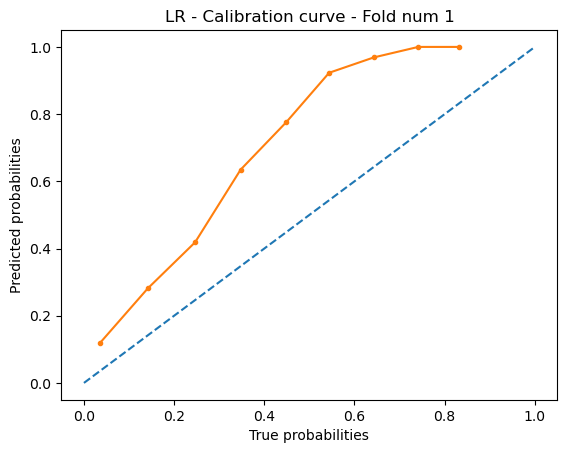

In [36]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve


fpr, tpr, thresholds = roc_curve(y_test,y_pred)
auc = auc(fpr, tpr)
auc

fold_num_print = 'Fold_num_1'
fold_title = 'Fold num 1'

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('LR - ROC curve - ' + str(fold_title))
plt.legend(loc='best')
plt.savefig('PAD_LR_auc_curve_'+str(fold_num_print)+'.jpeg')
plt.show()

# reliability diagram
fop, mpv = calibration_curve(y_test, y_pred, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.xlabel('True probabilities')
plt.ylabel('Predicted probabilities')
plt.title('LR - Calibration curve - '+ str(fold_title))
plt.savefig('PAD_LR_calibration_'+fold_num_print+'.jpeg')
plt.show()


In [37]:
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
optimal_threshold = thresholds[ix]
print("optimal_threshold = ", optimal_threshold)

cm=confusion_matrix(y_test, y_pred>optimal_threshold)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

cm,TP,TN,FP,FN,auc,TNR,TPR

print("AUC = ", auc)
print("Specificity = ", TNR)
print("Sensitivity = ", TPR)

import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


alpha = .95
# y_pred = np.array([0.21, 0.32, 0.63, 0.35, 0.92, 0.79, 0.82, 0.99, 0.04])
y_true = y_test

auc_delong, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc_delong,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc_delong)
# print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

d = {'auc': auc, 'specificity': TNR, 'sensitivity': TPR}
df = pd.DataFrame(data=d, index = [0], dtype=np.float64)
df.to_csv('auc_specificity_sensitivity_fold1.csv', index=False)

optimal_threshold =  0.08907585128924073
AUC =  0.8079627773927399
Specificity =  0.7385103011093502
Sensitivity =  0.7275766016713092
AUC: 0.8079627773927399
95% AUC CI: [0.78705706 0.8288685 ]


In [39]:
auc_std

0.010666378748359403

In [57]:
fold_num = 1
pd.DataFrame(fpr).to_csv("plots/fpr" + str(fold_num) + ".csv")
pd.DataFrame(tpr).to_csv("plots/tpr" + str(fold_num) + ".csv")
pd.DataFrame(fop).to_csv("plots/fop" + str(fold_num) + ".csv")
pd.DataFrame(mpv).to_csv("plots/mpv" + str(fold_num) + ".csv")
pd.DataFrame([auc]).to_csv("plots/auc" + str(fold_num) + ".csv")

In [732]:
len(y_pred)

2487

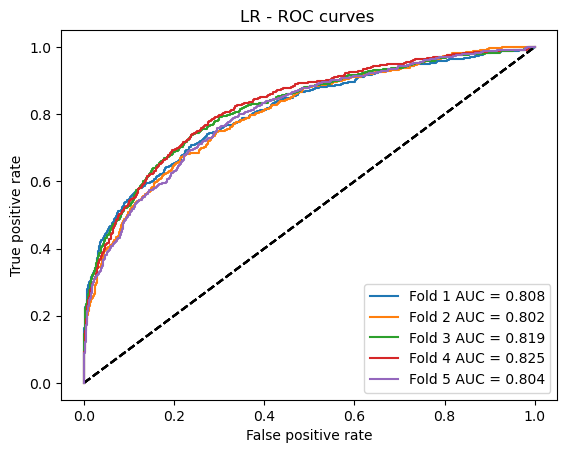

In [58]:
for i in range(1, 6):
    df_fpr = pd.read_csv("plots/fpr{fold_num}.csv".format_map({'fold_num': i}))['0']
    df_tpr = pd.read_csv("plots/tpr{fold_num}.csv".format_map({'fold_num': i}))['0']
    df_auc = pd.read_csv("plots/auc{fold_num}.csv".format_map({'fold_num': i}))['0']
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(df_fpr, df_tpr, label='Fold ' + str(i) + ' AUC = {:.3f}'.format(df_auc[0]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('LR - ROC curves ')
    plt.legend(loc='best')
    plt.savefig('PAD_LR_auc_curves.jpeg')
plt.show()

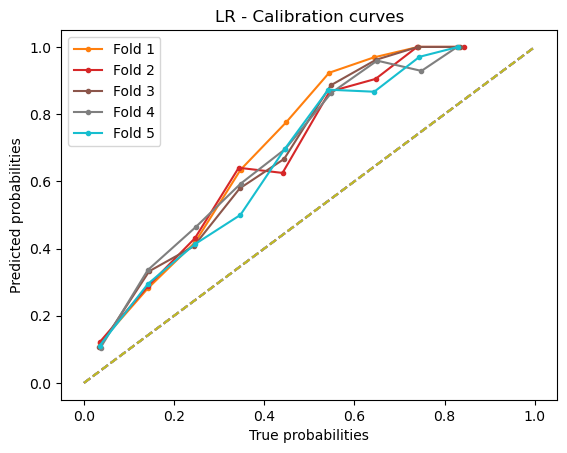

In [59]:
for i in range(1, 6):
    df_fop = pd.read_csv("plots/fop{fold_num}.csv".format_map({'fold_num': i}))['0']
    df_mpv = pd.read_csv("plots/mpv{fold_num}.csv".format_map({'fold_num': i}))['0']
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    plt.plot(df_mpv, df_fop, marker='.', label='Fold ' + str(i))
    plt.xlabel('True probabilities')
    plt.ylabel('Predicted probabilities')
    plt.title('LR - Calibration curves')
    plt.legend(loc='best')
    plt.savefig('PAD_LR_calibrations.jpeg')
plt.show()

In [60]:
aucs = []
specificitys = []
sensitivitys = []

for i in range(5):
    df = pd.read_csv('auc_specificity_sensitivity_fold' + str(i+1) + '.csv')  
    aucs.append(float(df['auc']))
    specificitys.append(float(df['specificity']))
    sensitivitys.append(float(df['sensitivity']))
    

In [61]:
["{:.3f}".format(v) for v in aucs]

['0.808', '0.802', '0.819', '0.825', '0.804']

In [62]:
["{:.3f}".format(v) for v in specificitys] 

['0.739', '0.745', '0.736', '0.777', '0.756']

In [63]:
["{:.3f}".format(v) for v in sensitivitys] 

['0.728', '0.707', '0.762', '0.723', '0.705']

In [64]:
np.mean(aucs)
"{:.3f}".format(np.mean(aucs))

'0.811'

In [65]:
np.mean(specificitys)
"{:.3f}".format(np.mean(specificitys))

'0.750'

In [66]:
np.mean(sensitivitys)
"{:.3f}".format(np.mean(sensitivitys))

'0.725'

# Nomogram scores

## Cases

In [75]:
query="""
CREATE OR REPLACE TABLE `{work_project_id}.{work_dataset_id}.Cases_FM_temp_nom` AS
SELECT *, 
(CASE 
WHEN 45 <= Age AND Age <= 49 THEN 0
WHEN 50 <= Age AND Age <= 54 THEN 1
WHEN 55 <= Age AND Age <= 59 THEN 2
WHEN 60 <= Age AND Age <= 64 THEN 3
WHEN 65 <= Age AND Age <= 69 THEN 4
WHEN 70 <= Age AND Age <= 74 THEN 5
WHEN 75 <= Age AND Age <= 79 THEN 6
WHEN 80 <= Age AND Age <= 84 THEN 7
WHEN 85 <= Age AND Age <= 89 THEN 8
WHEN 90 <= Age AND Age <= 94 THEN 9
WHEN 95 <= Age AND Age <= 99 THEN 10
WHEN 100 <= Age THEN 11
END) AS age_score,
(CASE 
WHEN Female = 0 THEN 0
WHEN Female = 1 THEN 4
ELSE 0
END) AS sex_score,
(CASE 
WHEN Race IN ('Black', 'Other') THEN 16
WHEN Race IN ('Caucasian', 'Hispanic') THEN 15
WHEN Race IN ('Asian') THEN 0
ELSE 15
END) AS race_score,
(CASE WHEN Diab = 1 THEN 4
ELSE 0
END) AS diab_score,
(CASE 
WHEN BMI <= 23 THEN 10
WHEN 23 <= BMI AND BMI <= 24 THEN 9
WHEN 24 <= BMI AND BMI <= 26 THEN 8
WHEN 26 <= BMI AND BMI <= 27 THEN 7
WHEN 27 <= BMI AND BMI <= 29 THEN 6
WHEN 29 <= BMI AND BMI <= 31 THEN 5
WHEN 31 <= BMI AND BMI <= 32 THEN 4
WHEN 32 <= BMI AND BMI <= 34 THEN 3
WHEN 34 <= BMI AND BMI <= 35 THEN 2
WHEN 35 <= BMI AND BMI <= 38 THEN 1
WHEN 38 <= BMI  THEN 0
ELSE 6
END) AS bmi_score,
(CASE WHEN HTN = 1 THEN 2
ELSE 0
END) AS htn_score,
(CASE WHEN new_Smoking_status = 'Current' THEN 13
ELSE 0
END) AS smoking_score,
(CASE WHEN CAD = 1 THEN 2
ELSE 0
END) AS cad_score,
(CASE WHEN CVA = 1 THEN 3
ELSE 0
END) AS cva_score,
(CASE WHEN HF = 1 THEN 9
ELSE 0
END) AS hf_score,
FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp_smok` 
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

query="""
CREATE OR REPLACE TABLE `{work_project_id}.{work_dataset_id}.Cases_FM_temp_nom` AS
SELECT *, (age_score + sex_score + race_score + diab_score + bmi_score + htn_score + smoking_score + cad_score + cva_score + hf_score) 
AS nomogram_score
FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp_nom` 
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

#SELECT person_id, PAD, Age, Female, Race, CVA, CAD, HF, HTN, Diab, HLD, BMI, new_Smoking_status, nomogram_score
query="""
CREATE OR REPLACE TABLE `{work_project_id}.{work_dataset_id}.Cases_FM_temp_nom` AS
SELECT person_id, nomogram_score, 1 AS label
FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp_nom`
WHERE person_id NOT IN (
SELECT *
FROM `{work_project_id}.{work_dataset_id}.321052_ids`)
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

""


In [76]:
query="""
SELECT *
FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp_nom` 
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

,person_id,nomogram_score,label
0,32559955,5,1
1,30414019,6,1
2,31291547,7,1
3,31350733,9,1
4,32383496,9,1
...,...,...,...
3163,30788737,66,1
3164,32461320,66,1
3165,31449876,67,1
3166,30910049,69,1


## Controls

In [77]:
query="""
CREATE OR REPLACE TABLE `{work_project_id}.{work_dataset_id}.Controls_FM_temp_nom` AS
SELECT *, 
(CASE 
WHEN 45 <= Age AND Age <= 49 THEN 0
WHEN 50 <= Age AND Age <= 54 THEN 1
WHEN 55 <= Age AND Age <= 59 THEN 2
WHEN 60 <= Age AND Age <= 64 THEN 3
WHEN 65 <= Age AND Age <= 69 THEN 4
WHEN 70 <= Age AND Age <= 74 THEN 5
WHEN 75 <= Age AND Age <= 79 THEN 6
WHEN 80 <= Age AND Age <= 84 THEN 7
WHEN 85 <= Age AND Age <= 89 THEN 8
WHEN 90 <= Age AND Age <= 94 THEN 9
WHEN 95 <= Age AND Age <= 99 THEN 10
WHEN 100 <= Age THEN 11
END) AS age_score,
(CASE 
WHEN Female = 0 THEN 0
WHEN Female = 1 THEN 4
ELSE 0
END) AS sex_score,
(CASE 
WHEN Race IN ('Black', 'Other') THEN 16
WHEN Race IN ('Caucasian', 'Hispanic') THEN 15
WHEN Race IN ('Asian') THEN 0
ELSE 15
END) AS race_score,
(CASE WHEN Diab = 1 THEN 4
ELSE 0
END) AS diab_score,
(CASE 
WHEN BMI <= 23 THEN 10
WHEN 23 <= BMI AND BMI <= 24 THEN 9
WHEN 24 <= BMI AND BMI <= 26 THEN 8
WHEN 26 <= BMI AND BMI <= 27 THEN 7
WHEN 27 <= BMI AND BMI <= 29 THEN 6
WHEN 29 <= BMI AND BMI <= 31 THEN 5
WHEN 31 <= BMI AND BMI <= 32 THEN 4
WHEN 32 <= BMI AND BMI <= 34 THEN 3
WHEN 34 <= BMI AND BMI <= 35 THEN 2
WHEN 35 <= BMI AND BMI <= 38 THEN 1
WHEN 38 <= BMI  THEN 0
ELSE 6
END) AS bmi_score,
(CASE WHEN HTN = 1 THEN 2
ELSE 0
END) AS htn_score,
(CASE WHEN Smoking_status = 'Current' THEN 13
ELSE 0
END) AS smoking_score,
(CASE WHEN CAD = 1 THEN 2
ELSE 0
END) AS cad_score,
(CASE WHEN CVA = 1 THEN 3
ELSE 0
END) AS cva_score,
(CASE WHEN HF = 1 THEN 9
ELSE 0
END) AS hf_score,
FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp_smok` 
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

query="""
CREATE OR REPLACE TABLE `{work_project_id}.{work_dataset_id}.Controls_FM_temp_nom` AS
SELECT *, (age_score + sex_score + race_score + diab_score + bmi_score + htn_score + smoking_score + cad_score + cva_score + hf_score) 
AS nomogram_score
FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp_nom` 
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

query="""
CREATE OR REPLACE TABLE `{work_project_id}.{work_dataset_id}.Controls_FM_temp_nom` AS
SELECT person_id, nomogram_score, 0 AS label
FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp_nom` 
WHERE person_id NOT IN (
SELECT *
FROM `{work_project_id}.{work_dataset_id}.321052_ids`)
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

""


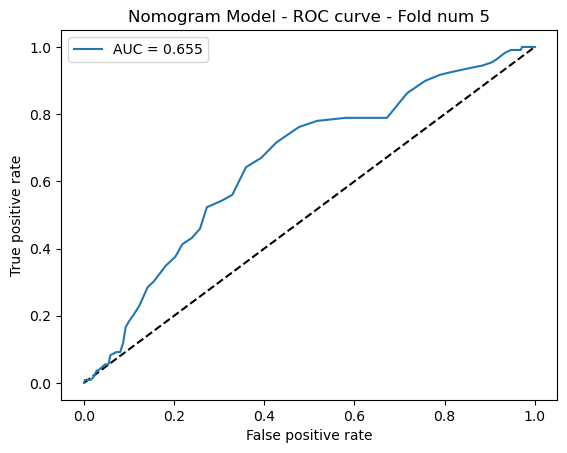

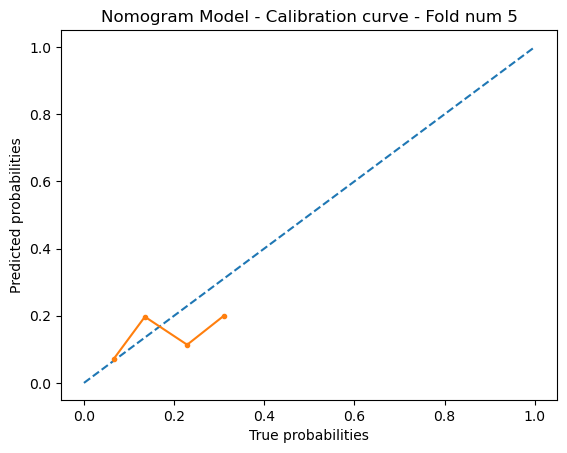

In [53]:
fold_num = 5
query="""
(SELECT a.*
FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp_nom` a
JOIN `{work_project_id}.{work_dataset_id}.person_ids_cases_sequence_fold_{fold_num}` b
ON a.person_id = b.person_id)
UNION ALL
(SELECT a.*
FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp_nom` a
JOIN `{work_project_id}.{work_dataset_id}.person_ids_controls_sequence_fold_{fold_num}` b
ON a.person_id = b.person_id)
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df
df.to_csv("data_nom_{fold_num}.csv".format_map({'fold_num': fold_num}), index=False, header=True)

df = pd.read_csv("data_nom_{fold_num}.csv".format_map({'fold_num': fold_num}))
df.head()

df = df.dropna()
df = df.drop("person_id",axis = 1)

X_nom = df.drop("label",axis = 1) 
y_nom = df.label

import pandas as pd
import numpy as np
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train_nom, X_test_nom, y_train_nom, y_test_nom = train_test_split(X_nom, y_nom, test_size=0.15, random_state=42)
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_nom, y_train_nom)
y_pred_nom = logistic_regression.predict_proba(X_test_nom)[:,1]

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve


fpr, tpr, thresholds_nom = roc_curve(y_test_nom,y_pred_nom)
auc = auc(fpr, tpr)
auc

fold_num_print = 'Fold_num_' + str(fold_num)
fold_title = 'Fold num ' + str(fold_num)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Nomogram Model - ROC curve - ' + str(fold_title))
plt.legend(loc='best')
plt.savefig('PAD_Nom_auc_curve_'+str(fold_num_print)+'.jpeg')
plt.show()

# reliability diagram
fop, mpv = calibration_curve(y_test_nom, y_pred_nom, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.xlabel('True probabilities')
plt.ylabel('Predicted probabilities')
plt.title('Nomogram Model - Calibration curve - '+ str(fold_title))
plt.savefig('PAD_Nom_calibration_'+fold_num_print+'.jpeg')
plt.show()


In [54]:
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
optimal_threshold = thresholds_nom[ix]
print("optimal_threshold = ", optimal_threshold)

cm=confusion_matrix(y_test_nom, y_pred_nom>optimal_threshold)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

cm,TP,TN,FP,FN,auc,TNR,TPR

print("AUC = ", auc)
print("Specificity = ", TNR)
print("Sensitivity = ", TPR)

import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


alpha = .95
# y_pred = np.array([0.21, 0.32, 0.63, 0.35, 0.92, 0.79, 0.82, 0.99, 0.04])
y_true = y_test_nom

auc_delong, auc_cov = delong_roc_variance(
    y_true,
    y_pred_nom)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc_delong,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc_delong)
# print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)
print('AUC STD:', auc_std)

d = {'auc': auc, 'specificity': TNR, 'sensitivity': TPR}
df = pd.DataFrame(data=d, index = [0], dtype=np.float64)
df.to_csv('nom_auc_specificity_sensitivity_fold'+ str(fold_num) +'.csv', index=False)

optimal_threshold =  0.08925424978323306
AUC =  0.6546633595314229
Specificity =  0.5596330275229358
Sensitivity =  0.6710097719869706
AUC: 0.6546633595314227
95% AUC CI: [0.60180527 0.70752145]
AUC STD: 0.026968909524760228


In [48]:
aucs = []
specificitys = []
sensitivitys = []

for i in range(5):
    df = pd.read_csv('nom_auc_specificity_sensitivity_fold' + str(i+1) + '.csv')  
    aucs.append(float(df['auc']))
    specificitys.append(float(df['specificity']))
    sensitivitys.append(float(df['sensitivity']))
    

In [99]:
["{:.3f}".format(v) for v in aucs]

['0.654', '0.621', '0.643', '0.659', '0.655']

In [100]:
["{:.3f}".format(v) for v in specificitys] 

['0.593', '0.639', '0.598', '0.704', '0.560']

In [101]:
["{:.3f}".format(v) for v in sensitivitys] 

['0.638', '0.561', '0.639', '0.574', '0.671']

In [102]:
np.mean(aucs)
"{:.3f}".format(np.mean(aucs))


'0.646'

In [103]:
np.mean(specificitys)
"{:.3f}".format(np.mean(specificitys))

'0.619'

In [104]:
np.mean(sensitivitys)
"{:.3f}".format(np.mean(sensitivitys))

'0.617'